# Industry Accelerators - Customer Attrition Prediction Models

## Introduction

In this notebook we will be going through an end-to-end project to load in long form transactional type data, prepare the data into a wide format, build some machine learning models, and then deploy those built models. This model predicts how likely the Attrition will occur in the life of a client within a certain period of time in the future (Forecast Horizon). Attrition is defined by the client being inactive or the value of the client's Assets Under Management (AUM) drops by a certain percentage over the period of a month. This model allows the organization to identify the clients who have a high likelihood of leaving or transferring their assets to another firm within a certain period of time. The model does this by tracking seasonality trends. The summary and demographic information is analyzed at a client level. The model input data structure is a wide form data structure (multiple rows per client), organized by `Customer ID` as the key field.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

## Load Customer Attrition Data

For this project we will be loading the csv file called **customer_history.csv**. The file is located in the `/project_data/data_asset/` directory. We use **project-lib** library to fetch and save the files associated with the project.

The easiest way to load in data is to use the <b>Find and Add Data</b> icon in the upper right hand corner. Once selected you will see a sidebar come out with options to load from either Files or Connections.

If you loaded your dataset into a Watson Studio analytics project, like a CSV file, then select Files and you should be able to find your dataset name. From there you can click the <b>Insert to code</b> and select to either insert a pandas dataframe or a spark dataframe. Once you make the selection you'll see python code inserted into the notebook cell with either Pandas or PySpark code for reading in your data. Now you're ready to explore and manipulate your dataset. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

import importlib
import warnings
import sys
import time

from project_lib import Project
project = Project()

warnings.filterwarnings('ignore')
if '/project_data/data_asset' not in sys.path:
    sys.path.insert(0, '/project_data/data_asset')
    
import attrition_prep
from attrition_prep import AttritionPrep

np.random.seed(0)

## User Inputs and Data Prep

### User Inputs

**train_or_score :** Specify whether we are prepping the data for training or for scoring. Training data includes the target variable while scoring dataset will not.<br>
**effective_date_earliest :** The start point for model training. Any data from before this date is removed during the prep.<br>
**effective_date_latest :** The last date for model training. Any data after this date is removed from the dataset when training.<br>
**effective_date :** Used for scoring. This is the date that the prediction is computed. The scoring observation window and forecast horizon are calculated from this date.<br>

**columns_required :**  A list of default columns required, includes ID column, date columns and columns used to define attrition<br>
**feature_required :**  The user should define the columns that are to be used as input features here.<br>
**derive_column_list :**  The user specifies the numerical variables that summary statistics are computed for. Should be a subset of feature_required<br>
**sum_list :**  If the user would like to create features by summing the data over the observation window, the columns are listed here. Should be a subset of derive_column_list.<br>

Since column names will not always be the same, we assign variable names to the column names used for prepping the data.

**granularity_key :** Specifies the customer ID column.<br>
**target_attribute :** Name of the target column.<br>
**status_attribute :** Column which indicates whether the customer is active or inactive and is used to define attrition.<br>
**funds_attribute :** Funds under management column. This column is also used to define attrition.<br>
**date_customer_joined :** Specifies the column where the customer join date is recorded. This variable is used to calculate customer tenure.<br>
**customer_end_date :** Column with month that summary data is for. Last day in month. Used for calculating forecast_horzon and observation_windows for customers.<br>
**customer_start_date :** Similar to customer_end_date, but with the first day in the month.<br>
**period_attribute :** Column name for the tenure feature. This feature is calculated from customer_end_date and date_customer_joined.<br>
**status_flag_attrition :** The name of the variable in the status_attribute that indicates that the customer has attrited, in this case it is 'Inactive'.<br>

**AUM_reduction_threshold :** This is the ratio by which the assets under management (AUM) will drop by in a month for attrition to take place<br>
**forecast_horizon :** The window of time that we want to predict in. This is the number of months after a cutoff date in which attrition can occur.<br>
**observation_window :** The lookback period from the cutoff date. Our summary statistics are calculated over this time period. <br>
**cat_threshold :** We remove categorical variables with cardinality greater than this threshold.

The user can use the default inputs or can choose their own. The user inputs are stored and the same inputs will be applied automatically at scoring time. 

### Data Prep

See `/project_data/data_asset/attrition_prep.py` for details of data preparation.

The script generates the dataset that is used for modelling. We take a wide form dataset with customer details, customer summary over time and aggregate account statistics, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for modelling.

The script also stamps each customer with the target variable, whether they attrited or not. A customer has attrited if their status becomes ‘Inactive’ or if their funds under management drops by a specified percentage (AUM_threshold) or more in a month.

The final dataset consists of data from the latest month we saw the customer as well as summary statistics over a period in their history. 


### Data Cleaning
•	We remove customers without enough historical data.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 10% null values is removed.<br>
•	High cardinality categorical columns are removed.<br>
•	Any column name that that ends with ‘TIMESTAMP’ or ‘ROW_ID’ is removed.<br>
•	Remaining missing values are left in place. During training, the user can decide how to handle the remaining missing values.

In [2]:
# data prep input variables
train_or_score = 'train'
effective_date_earliest='2016-01-01'
effective_date_latest='2018-09-30'
effective_date='2018-09-30'
columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE',
                  'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_EFFECTIVE_DATE',
                  'CUSTOMER_RELATIONSHIP_START_DATE']
feature_attributes=['CUSTOMER_AGE_RANGE', 'CUSTOMER_GENDER', 'CUSTOMER_EDUCATION_LEVEL',
                    'CUSTOMER_URBAN_CODE', 'CUSTOMER_MARKET_GROUP', 'CUSTOMER_EMPLOYMENT_STATUS',
                    'CUSTOMER_MARITAL_STATUS', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 
                    'CUSTOMER_NUMBER_OF_DEPENDENT_ADULTS', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN', 
                    'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 
                    'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE',
                    'CUSTOMER_INTERNET_BANKING_INDICATOR', 'CUSTOMER_FAMILY_SIZE',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
derive_column_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE", "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS",
                    "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT", "CUSTOMER_SUMMARY_NON_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_NUMBER_OF_MOBILE_LOGINS", "CUSTOMER_SUMMARY_NUMBER_OF_LOGINS"]
granularity_key="CUSTOMER_CUSTOMER_ID"
target_attribute='TARGET'
status_attribute='CUSTOMER_STATUS'
funds_attribute='CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
period_attribute='CUSTOMER_TENURE'
status_flag_attrition='Inactive'
AUM_reduction_threshold=0.75
forecast_horizon=6
observation_window=6
sum_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE",
          "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS"]
cat_threshold=10

In [3]:
customer_history_file = project.get_file("customer_history.csv")
customer_history_file.seek(0)

df_raw = pd.read_csv(customer_history_file,
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                                  'CUSTOMER_SUMMARY_START_DATE'], 
                     infer_datetime_format=True)

data_prep = AttritionPrep(train_or_score, effective_date_earliest, effective_date_latest, effective_date,
                      columns_required, feature_attributes, derive_column_list, granularity_key,
                      target_attribute, status_attribute, funds_attribute, date_customer_joined, 
                      customer_end_date, customer_start_date, period_attribute, status_flag_attrition,
                      AUM_reduction_threshold, forecast_horizon, observation_window, sum_list,
                      cat_threshold)

df_prepped = data_prep.prep_data(df_raw, 'train')
df_prepped.head()

Dataframe shape: (19251, 31)
Count of customers: 1000
162 customers attrited
Columns available for deriving features: ['CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT']
Prepped data for 162 customers
Finished prepping for attrited customers
Prepped data for 561 customers
Finished prepping for non-attrited customers


,CUSTOMER_FAMILY_SIZE,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY,CUSTOMER_ANNUAL_INCOME,CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,TARGET,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std_norm,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_current_vs_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_sum,CUSTOMER_TENURE,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_MARITAL_STATUS_Married,CUSTOMER_MARITAL_STATUS_Single,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,CUSTOMER_EMPLOYMENT_STATUS_Homemaker,CUSTOMER_EMPLOYMENT_STATUS_Retired,CUSTOMER_EMPLOYMENT_STATUS_Selfemployed,CUSTOMER_EMPLOYMENT_STATUS_Unemployed,CUSTOMER_GENDER_Male
0,2,0.0,0.0,0,750000.0,0.0,0,0.0,0.0,655000.0,1,0.0,0.0,1417.080532,0.0,0.0,2,1,1205.895888,682.349564,177.367675,2066.858831,750000.0,750000.0,750000.0,0.565845,1.175127,7235.375326,20,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1,4,0.0,0.0,0,150000.0,0.0,2,0.0,0.0,580000.0,0,0.0,0.0,766.447177,0.0,0.0,3,1,1083.573374,460.619376,322.448390,1586.252154,150000.0,150000.0,150000.0,0.425093,0.707333,6501.440244,19,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,2,0.0,0.0,0,180000.0,0.0,0,0.0,0.0,135000.0,0,0.0,0.0,1126.965752,0.0,0.0,3,1,1303.866785,323.284549,995.936016,1758.018660,180000.0,180000.0,180000.0,0.247943,0.864326,7823.200712,20,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1
3,2,0.0,0.0,1,1250000.0,0.0,1,0.0,0.0,590000.0,0,0.0,0.0,1172.303938,0.0,0.0,2,1,1291.962891,460.112704,660.974400,1895.694947,1250000.0,1250000.0,1250000.0,0.356135,0.907382,7751.777344,20,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0.0,0.0,1,1250000.0,0.0,0,0.0,0.0,480000.0,2,0.0,0.0,2235.962616,0.0,0.0,2,1,1793.042669,733.219060,510.145715,2559.979319,1250000.0,1250000.0,1250000.0,0.408924,1.247021,10758.256017,21,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1


### Display Distribution of Target Variable

For any classification problem, it is important to check the distribution of the target variable in order to determine if the classes are severely unbalanced. The following code allows us to visualize the split between positive and negative attrition as a pie chart.

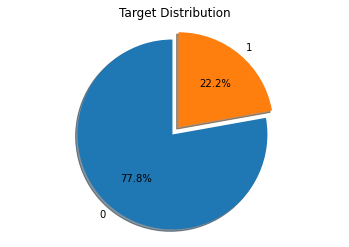

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1, ax1 = plt.subplots()
ax1.pie(df_prepped['TARGET'].value_counts(), labels=['0', '1'], explode=(0, 0.1),
        autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Target Distribution')

plt.show()

### Correlation Analysis
It is important to check for multi-collinearity among features when doing regression analysis. The presence of collinear features detracts from the impact of those features. When dealing with highly collinear features, one of them should be removed.

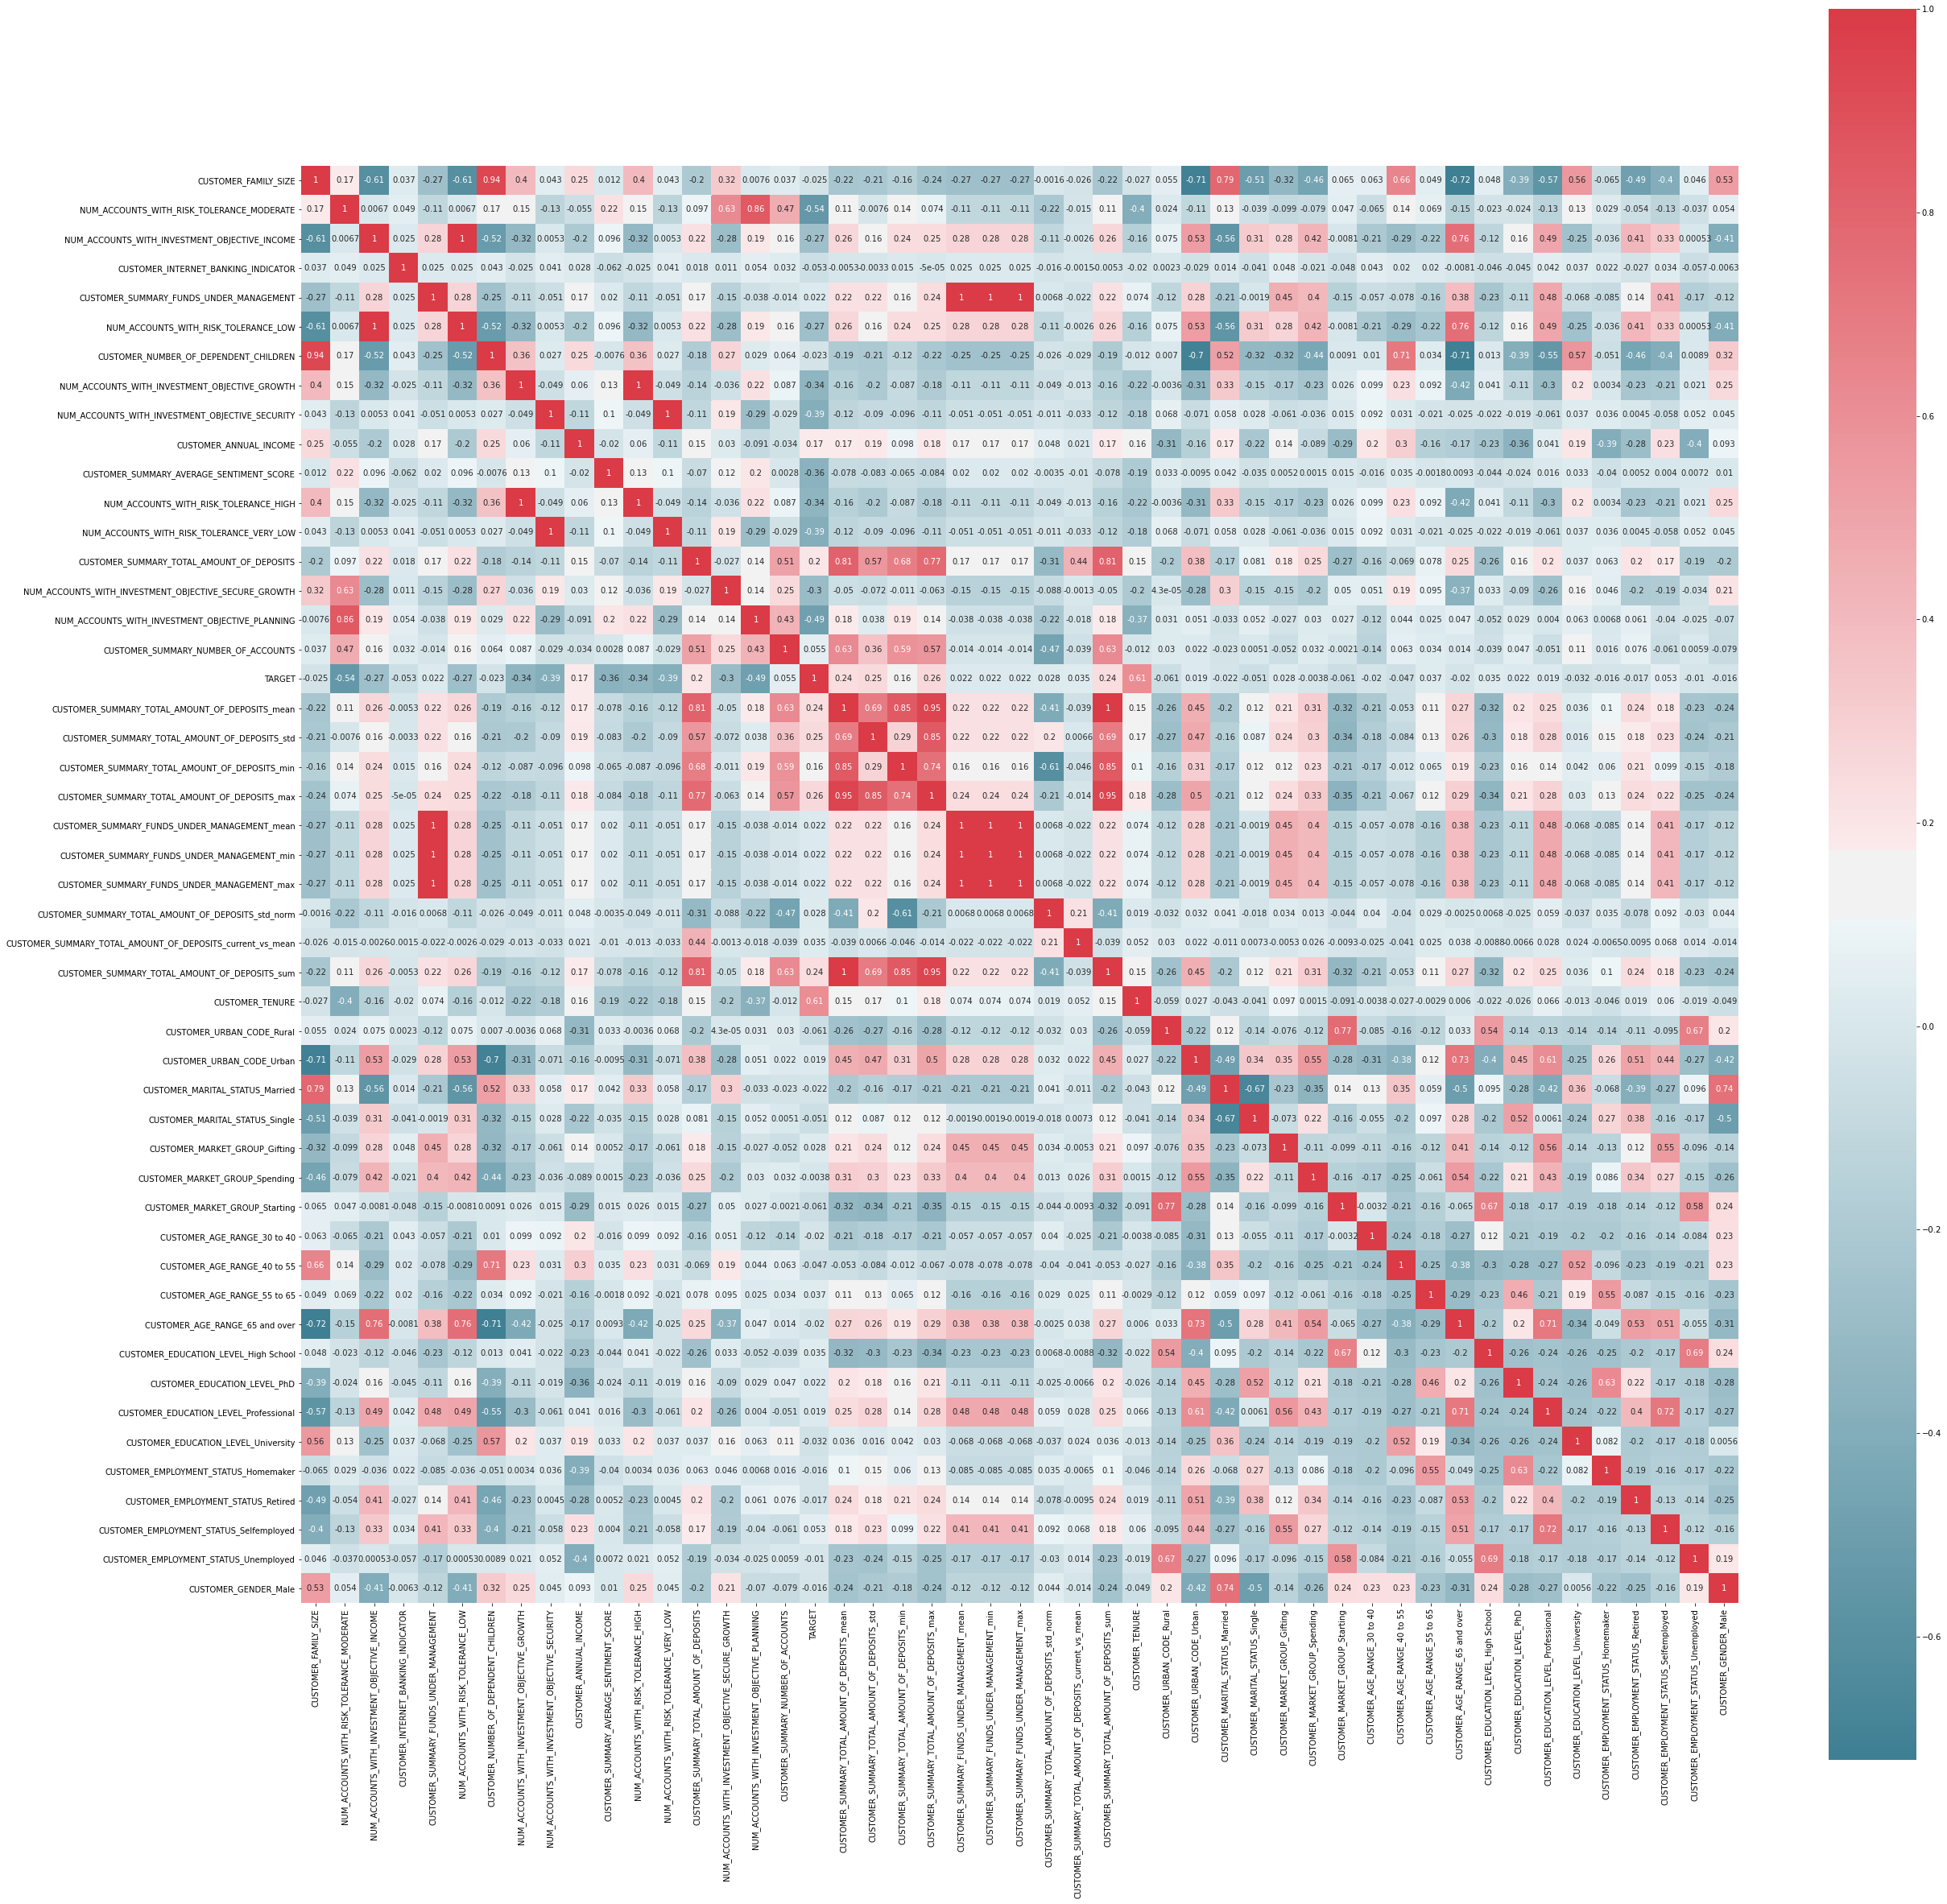

In [5]:
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(40, 40))
corr = df_prepped.corr()
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

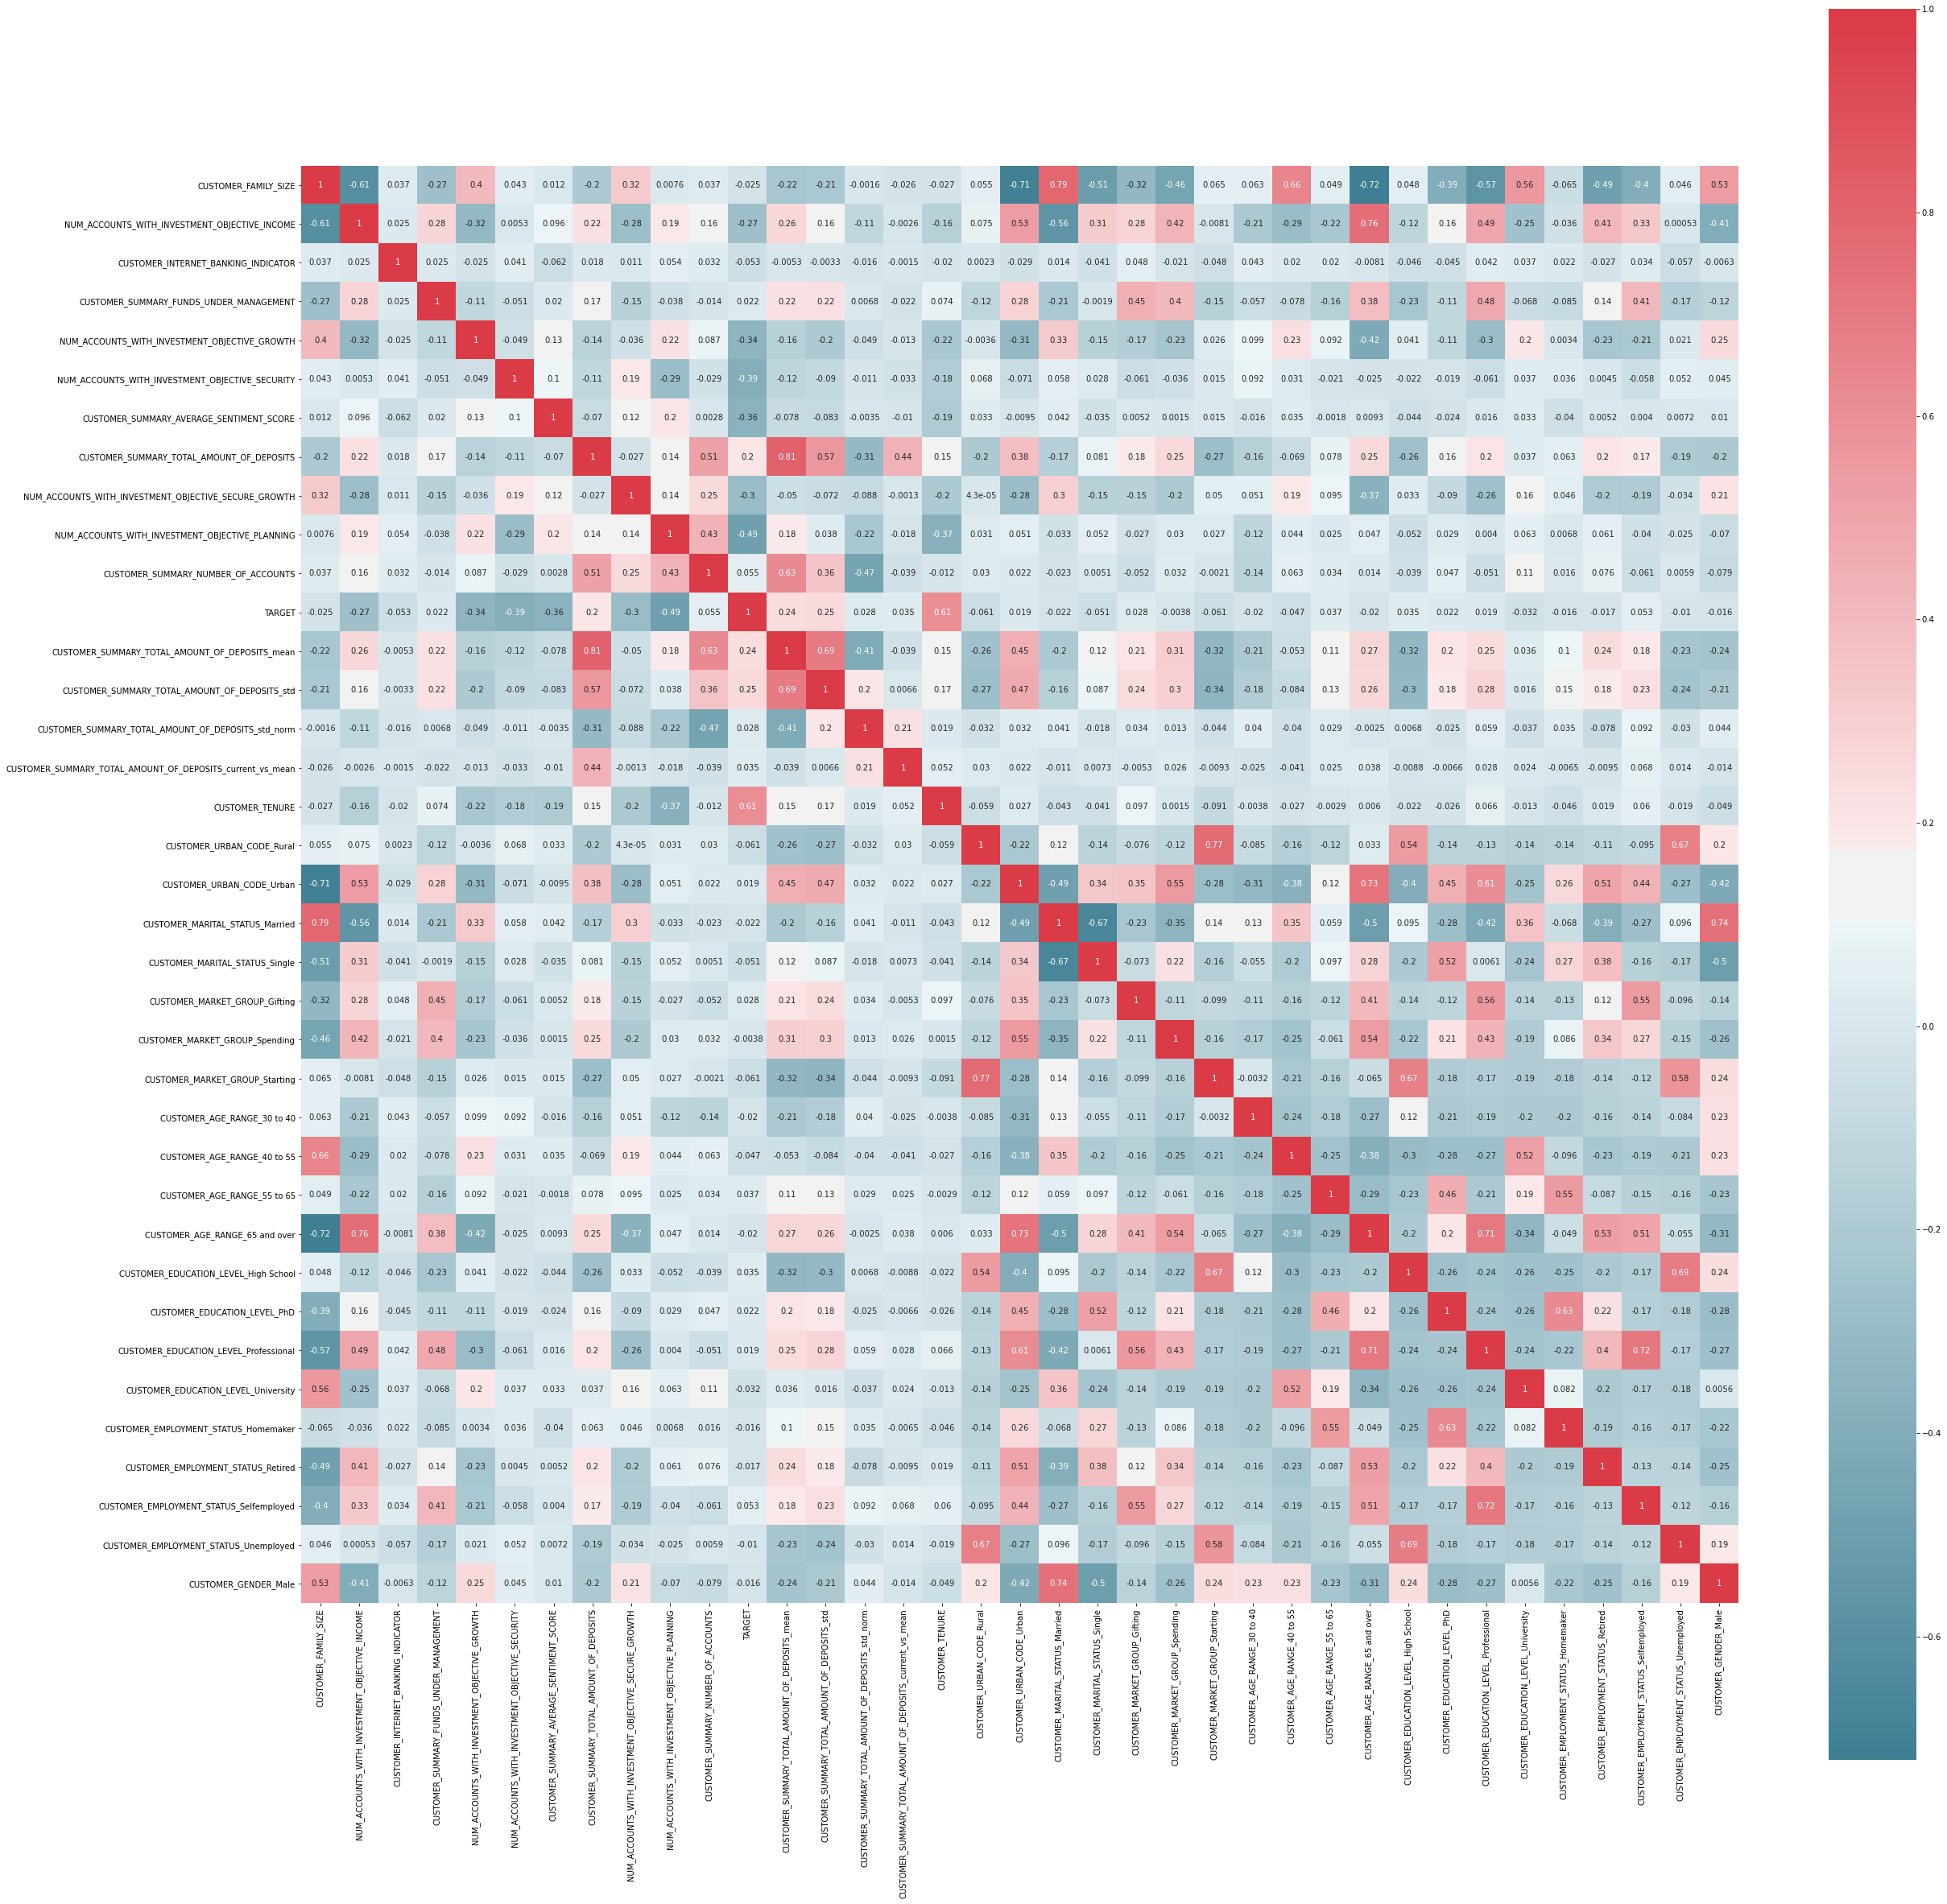

In [6]:
to_drop_corr = ['CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min',
           'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min',
           'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_sum',
           'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN',
           'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH',
           'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW']

df_prepped = df_prepped.drop(to_drop_corr, axis=1)

f, ax = plt.subplots(figsize=(40,40))
corr = df_prepped.corr()
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

### Display Prepared Data

Now that the data is ready for analysis, we will take a quick look at the dataset to ensure that everything is as expected.

In [7]:
print('\nTraining Data for Customer Attrition Use Case:')
display(df_prepped.head())
print("{} rows, {} columns\n".format(*df_prepped.shape))


Training Data for Customer Attrition Use Case:


,CUSTOMER_FAMILY_SIZE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY,CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,TARGET,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std_norm,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_current_vs_mean,CUSTOMER_TENURE,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_MARITAL_STATUS_Married,CUSTOMER_MARITAL_STATUS_Single,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,CUSTOMER_EMPLOYMENT_STATUS_Homemaker,CUSTOMER_EMPLOYMENT_STATUS_Retired,CUSTOMER_EMPLOYMENT_STATUS_Selfemployed,CUSTOMER_EMPLOYMENT_STATUS_Unemployed,CUSTOMER_GENDER_Male
0,2,0.0,0,750000.0,0.0,0.0,1,1417.080532,0.0,0.0,2,1,1205.895888,682.349564,0.565845,1.175127,20,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1,4,0.0,0,150000.0,0.0,0.0,0,766.447177,0.0,0.0,3,1,1083.573374,460.619376,0.425093,0.707333,19,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,2,0.0,0,180000.0,0.0,0.0,0,1126.965752,0.0,0.0,3,1,1303.866785,323.284549,0.247943,0.864326,20,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1
3,2,0.0,1,1250000.0,0.0,0.0,0,1172.303938,0.0,0.0,2,1,1291.962891,460.112704,0.356135,0.907382,20,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0.0,1,1250000.0,0.0,0.0,2,2235.962616,0.0,0.0,2,1,1793.042669,733.219060,0.408924,1.247021,21,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1


721 rows, 37 columns



In [8]:
to_drop_more = ['CUSTOMER_TENURE', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING',
                'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
df_prepped = df_prepped.drop(to_drop_more, axis=1)

### Splitting the Data

We set up our feature inputs and our outcome variable also called the $X$ and $y$ values. Our $X$ values will be the features we use in our model while $y$ is the output or what we'll try and predict. After we set up the appropriate $X$ and $y$ values then we split our data into train and test data sets using a common 80:20 split with 80% of the data being used for training our model and 20% being held out to test or validate our model.

When we split our datset we want to do a stratified sampling using our outcome variable with the `stratify=y_output` parameter. This ensures that when we split our dataset we maintain the proportions or balance of the outcome variable, `y_output`, from the original dataset to within both train and test datasets.

Finally, we set the seed using `random_state=1234` parameter for reproducibility purposes.

In [9]:
from sklearn.model_selection import train_test_split

X_inputs = df_prepped.drop(['TARGET'], axis=1)
y_output = df_prepped['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output,
                                                    test_size=0.20, random_state=1234)

print("Train and Test Data Dimensions:")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape:  {}".format(X_test.shape))
print("y_test shape:  {}".format(y_test.shape))

Train and Test Data Dimensions:
X_train shape: (576, 33)
y_train shape: (576,)
X_test shape:  (145, 33)
y_test shape:  (145,)


## Building Machine Learning Models
 The final phase, and the most fun part, is the modeling. We'll train and validate 3 types of models:<br>
 1. Logistic Regression
 2. Random Forests
 3. Gradient Boosting for Classification
 
For each of these models we'll fit our model and test the model showing accuracy metrics for both the training and testing data. Then we'll look at the confusion matrices, for both train and test data, to see where the model is classifying best across the binary labels. Finally for the random forests and the gradient boosting models we'll look at the variable importance plots. Let's take a look at training these models and their accuracies.

### Model Fitting
First step is to build the classifier and then fit a classifier on your $X$ and $y$ training data for our datasets. Let's fit the 3 models mentioned above.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Logistic Regression, Random Forest, and Gradient Boost
lr_model = LogisticRegression(penalty='l1', solver='saga', tol=0.1).fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=1234).fit(X_train, y_train)
gb_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=12, random_state=1234).fit(X_train, y_train)

models = {"Logistic Regression": lr_model,
          "Random Forest": rf_model,
          "Gradient Boosting": gb_model}

### Plot Confusion Matrices

We want to see where the model is misclassifying across our binary labels. For that we'll look at our confusion matrix.

**`plot_confusion_matrix`**: This function plots an annotated and more presentable confusion matrix for the classification model results

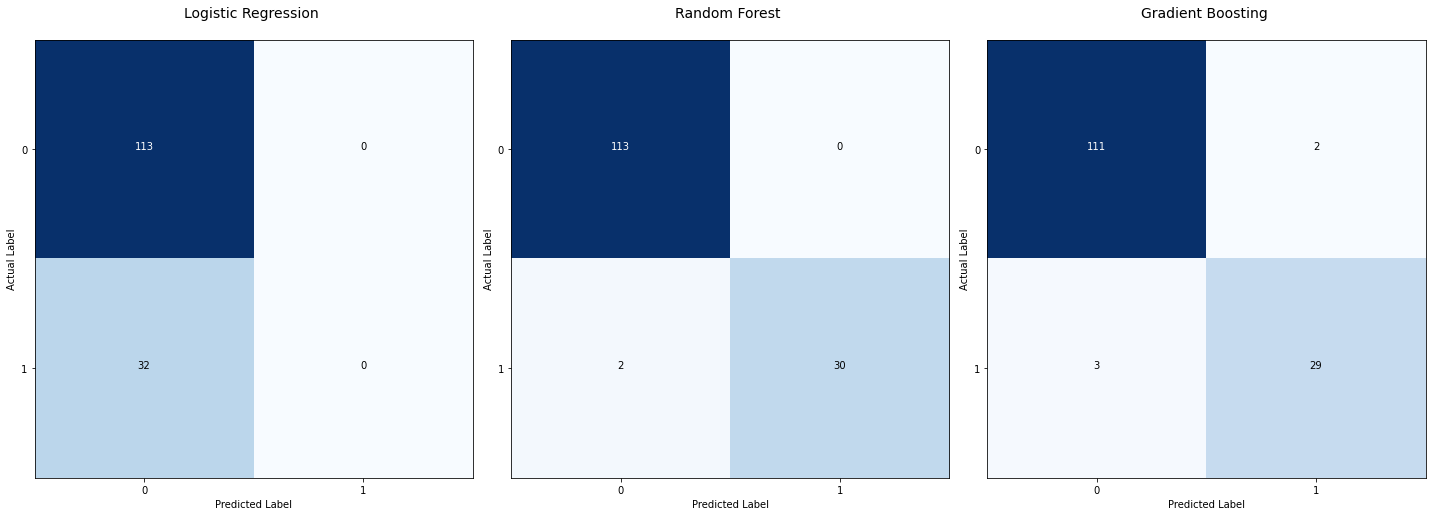

In [11]:
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Iterate over model types, calculating and then plotting confusion matrices
fig  = plt.figure(figsize=(20,10))
plot = 1

for model_type, model in models.items():
    y_pred_test = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test, labels=[0,1])

    fig.add_subplot(130+plot)
    plot_confusion_matrix(confusion_matrix, normalize=False, classes=['0','1'], title=model_type+' \n')
    plot += 1

### View Model Test Accuracies

There are several metrics of model performance that we can check. For this project, we choose to view the model accuracy.

In [12]:
acc = pd.DataFrame(columns = ['Type', 'accuracy'])
for model_type, model in models.items():
    acc = acc.append({'Type': model_type, 'accuracy': round(model.score(X_test, y_test),4)}, ignore_index=True)
acc.set_index('Type',inplace=True)

print("\nModel Test Accuracy : ")
acc


Model Test Accuracy : 


,accuracy
Type,
Logistic Regression,0.7793
Random Forest,0.9862
Gradient Boosting,0.9655


The Random Forest model has the highest performance, so we select that model to move forward with.

### Plot Feature Importance

With tree based models you can view variable importance plots. These plots indicate, at the feature level, some importance for the variable to classify the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the best performing models. The top models in terms of accuracy were random forest and gradient boosting.

**`plot_feature_importance`**: This plots an annotated and more presentable variable importance plot for the top 10 variables.

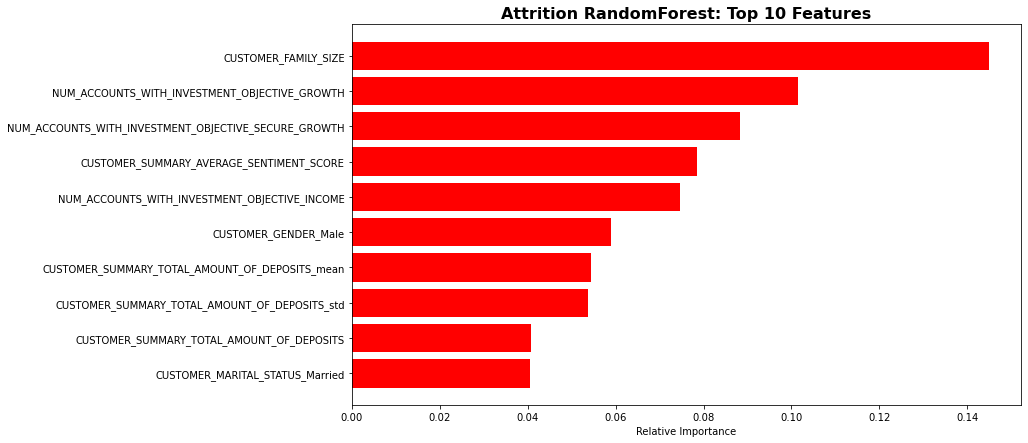

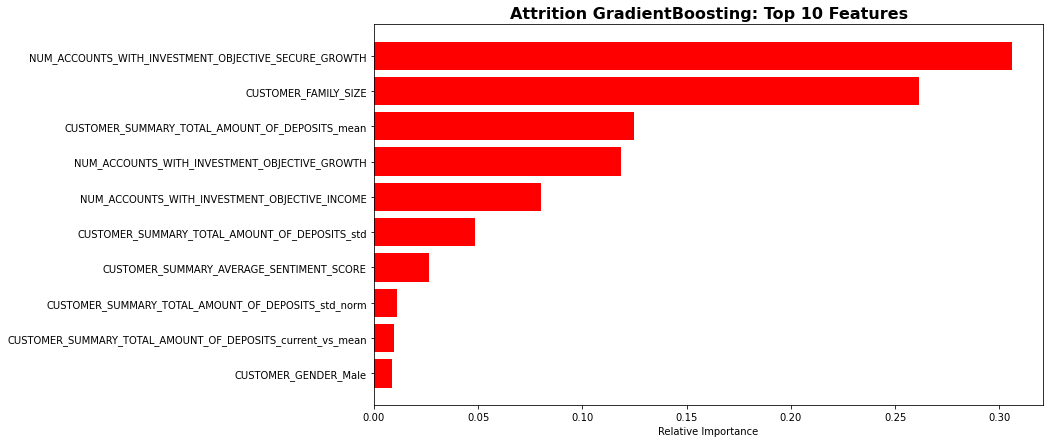

In [13]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    

# show feature importances of RandomForest and GradientBoost models
plot_feature_importance(feature_list=X_train.columns.tolist(), 
                        feature_importances=models['Random Forest'].feature_importances_, 
                        title="Attrition RandomForest: Top 10 Features")
plot_feature_importance(feature_list=X_train.columns.tolist(), 
                        feature_importances=models['Gradient Boosting'].feature_importances_, 
                        title="Attrition GradientBoosting: Top 10 Features")

## Save the best classification model to Cloud Pak for Data

As it is the top performing model, we select the Random Forest model for scoring new data. In the next steps we save and deploy the model. 

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 
The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.


### User Inputs

The user can specify the name for the space, models and model deployments.  <br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to `True`.

In [14]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Customer Attrition Space'
model_name = 'Customer Attrition Prediction Model'
deployment_name = 'Customer-Attrition-Prediction-Model-Deployment'

use_existing_space=True

Below code imports `ibm-watson-machine-learning` library and then creates a wml client using the credentials provided.

In [15]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. 

By default, if the space name already exists, the existing space will be used to store and deploy models and functions.

In [16]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with name",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(10)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Customer Attrition Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)


### Store the Model Details

Store the random forest model in the deployment space. The name for the model is specified in the user inputs cell above. Software specification, default tag and input data schema for the model are specified in the model metadata. Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()` <br>
Input data schema includes the structure of the training data. It can be used to enter the input data to score new data in the deployment space.
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 


In [17]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.TAGS: ['attrition_model_tag']
}
stored_model_details = client.repository.store_model(model=models['Random Forest'], meta_props=metadata, training_data=X_train, training_target=y_train, feature_names = list(X_train.columns))
stored_model_details

{'entity': {'label_column': 'TARGET',
  'schemas': {'input': [{'fields': [{'name': 'CUSTOMER_FAMILY_SIZE',
       'type': 'int64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
       'type': 'float64'},
      {'name': 'CUSTOMER_INTERNET_BANKING_INDICATOR', 'type': 'int64'},
      {'name': 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'type': 'float64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH',
       'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE', 'type': 'int64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'type': 'float64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
       'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 'type': 'int64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean',
       'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std',
       'type': 'float64'},
      {'name': 'CUSTOMER_S

### Deploy the Model 

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

In [18]:
# Meta_props for the model deployment
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['attrition_deployment_tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.DESCRIPTION:"Customer Attrition Prediction model to predict how likely the Attrition will occur in the life of a client within a certain period of time in the future",
    
}

# deploy the model
model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)







#######################################################################################

Synchronous deployment creation for uid: '31751188-4bcf-4ac3-b184-54f246405ab4' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='6dac5950-57fc-4801-af4a-a3adcda5da6f'
------------------------------------------------------------------------------------------------




### Operationalize the models

Now we are ready to operationalize our best model. See notebook **`2-model-scoring_and_app_deployment`** for the next step.